In [2]:
#!/usr/bin/env python3.7

# Copyright 2023, Gurobi Optimization, LLC

# Solve a traveling salesman problem on a randomly generated set of
# points using lazy constraints.   The base MIP model only includes
# 'degree-2' constraints, requiring each node to have exactly
# two incident edges.  Solutions to this model may contain subtours -
# tours that don't visit every city.  The lazy constraint callback
# adds new constraints to cut them off.

import sys
import math
import random
from itertools import combinations
import gurobipy as gp
from gurobipy import GRB

In [17]:
# Parse argument
#if len(sys.argv) < 2:
#    print('Usage: tsp.py npoints')
#    sys.exit(1)
#n = int(sys.argv[1])

n = 20

# Create n random points
random.seed(1)
points = [(random.randint(0, 100), random.randint(0, 100)) for i in range(n)]

# Dictionary of Euclidean distance between each pair of points
dist = {(i, j):
        math.sqrt(sum((points[i][k]-points[j][k])**2 for k in range(2)))
        for i in range(n) for j in range(i)}

In [18]:
X = [x[0] for x in points]
Y = [y[1] for y in points]

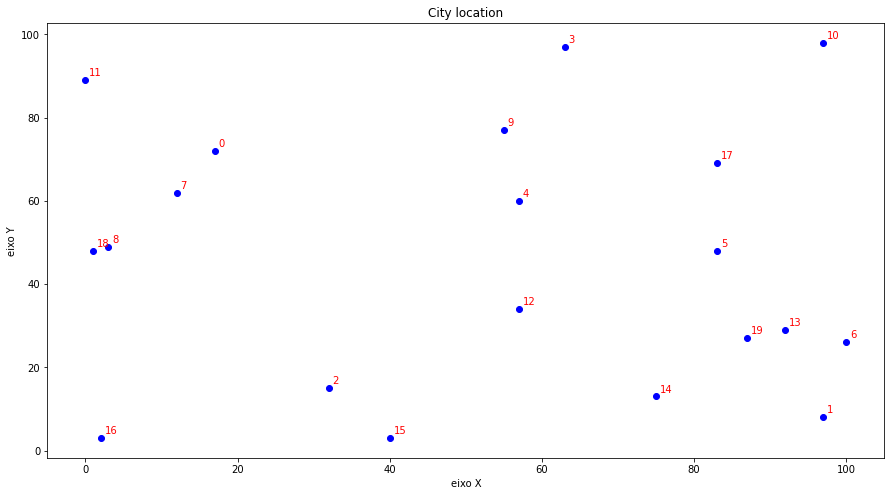

In [19]:
# grafic

import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.scatter(X,Y,color='blue')

for t in range(len(X)):
    plt.annotate(str(t), xy=(X[t],Y[t]), xytext = (X[t]+0.5, Y[t]+1), color='red')

plt.xlabel("eixo X")
plt.ylabel("eixo Y")
plt.title("City location")
plt.show()

In [20]:
# Given a tuplelist of edges, find the shortest subtour
def subtour(vals):
    # make a list of edges selected in the solution
    edges = gp.tuplelist((i, j) for i, j in vals.keys()
                         if vals[i, j] > 0.5)
    unvisited = list(range(n))
    cycle = range(n+1)  # initial length has 1 more city
    while unvisited:  # true if list is non-empty
        thiscycle = []
        neighbors = unvisited
        while neighbors:
            current = neighbors[0]
            thiscycle.append(current)
            unvisited.remove(current)
            neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
        if len(cycle) > len(thiscycle):
            cycle = thiscycle
    return cycle

In [21]:
# Callback - use lazy constraints to eliminate sub-tours
def subtourelim(model, where):
    if where == GRB.Callback.MIPSOL:
        vals = model.cbGetSolution(model._vars)
        # find the shortest cycle in the selected edge list
        tour = subtour(vals)
        if len(tour) < n:
            # add subtour elimination constr. for every pair of cities in tour
            model.cbLazy(gp.quicksum(model._vars[i, j]
                                     for i, j in combinations(tour, 2))
                         <= len(tour)-1)

In [22]:
# Create model
model = gp.Model()

# Create variables
vars = model.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='e')
for i, j in vars.keys():
    vars[j, i] = vars[i, j]  # edge in opposite direction

# You could use Python looping constructs and m.addVar() to create
# these decision variables instead.  The following would be equivalent
# to the preceding m.addVars() call...
#
# vars = tupledict()
# for i,j in dist.keys():
#   vars[i,j] = model.addVar(obj=dist[i,j], vtype=GRB.BINARY,
#                        name='e[%d,%d]'%(i,j))

# Add degree-2 constraint
model.addConstrs(vars.sum(i, '*') == 2 for i in range(n))

# Using Python looping constructs, the preceding would be...
#
# for i in range(n):
#   model.addConstr(sum(vars[i,j] for j in range(n)) == 2)

# Optimize model
model._vars = vars
model.Params.LazyConstraints = 1
model.optimize(subtourelim)

vals = model.getAttr('X', vars)
tour = subtour(vals)
assert len(tour) == n

print('')
print('Optimal tour: %s' % str(tour))
print('Optimal cost: %g' % model.ObjVal)
print('')

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: Intel(R) Core(TM) i5-1035G1 CPU @ 1.00GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 20 rows, 190 columns and 380 nonzeros
Model fingerprint: 0x32ae205a
Variable types: 0 continuous, 190 integer (190 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Presolve time: 0.00s
Presolved: 20 rows, 190 columns, 380 nonzeros
Variable types: 0 continuous, 190 integer (190 binary)

Root relaxation: objective 4.484281e+02, 31 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  448.42814    0    6          -  448.42814      -

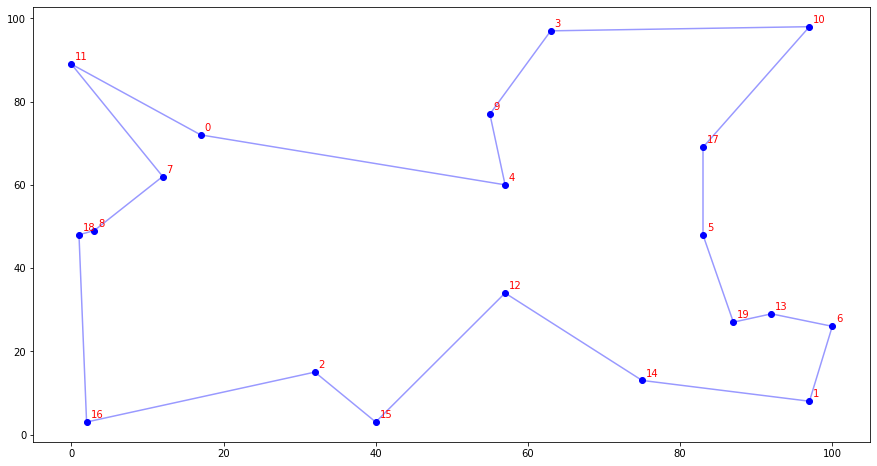

In [25]:
# grafic sol

def grafic_sol(vars, X, Y):
    arcos_ativos = [e for e in dist.keys() if vars[e].x > 0.9]
    #print(arcos_ativos)

    plt.figure(figsize = (15,8))
    plt.xlabel
    plt.ylabel

    plt.scatter(x=X, y=Y, color='blue', zorder=1)

    # line between arcos
    for i,j in arcos_ativos:
        plt.plot([X[i],X[j]],[Y[i],Y[j]], color='b', alpha=0.4, zorder=0)

    for t in range(len(X)):
        plt.annotate(str(t), xy=(X[t],Y[t]), xytext=(X[t]+0.5, Y[t]+1), color='red')

    plt.show()

# grafic assigment sol
grafic_sol(vars, X, Y)